# <center>PCA, ICA, NMF</center>

## <center>- SÉPARATION DE SOURCES AUDIO PAR ICA -</center>

In [1]:
import pylab as pl
import numpy as np
import wave
from scipy.io import wavfile as wav

from sklearn import decomposition

import IPython.display as ipd
from sklearn.decomposition import FastICA

#### 1. Étudier le script ica_audio.py et l’utiliser pour générer le mélange stéréo. Prendre le temps d’écouter les différents signaux.

In [2]:
# ica_audio.py
# Author: Slim Essid
# -- Read audio data ----------------------------------------------------------
def wavread(filename):
    wf = wave.open(filename)
    s = np.frombuffer(wf.readframes(wf.getnframes()), dtype=np.int16)
    wf.close()
    return s

def wavwrite(filename, s, nchannels=1): 
    wf = wave.open(filename,'wb') 
    wf.setnchannels(nchannels) 
    wf.setsampwidth(2)
    wf.setframerate(32000)
    s = s/max(abs(s))*2**14 # normalise arbitrarily 
    wf.writeframes(s.astype(np.int16).tostring())
    wf.close()
    
s1 = wavread('./snd/es02.wav')
s2 = wavread('./snd/si01.wav')

# -- Create stereo mix ---------------------------------------------------------
nsmp = min(len(s1), len(s2)) 
s1 = s1[:nsmp]
s2 = s2[:nsmp]
S = np.c_[s1, s2]
# Mixing matrix
A = np.array([ [0.6, 0.5],
              [0.4, 0.5]
             ])
# Do the mix
X = S.dot(A)
# Write mix file
x = np.zeros(2*nsmp)
x[::2] = X[:,0]
x[1::2] = X[:,1]
wavwrite('./snd/mix.wav', x, nchannels=2)


In [3]:
ipd.Audio('./snd/mix.wav')

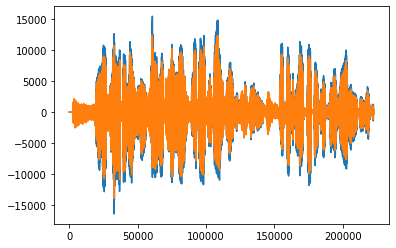

In [4]:
rate, mix_data = wav.read('./snd/mix.wav')
pl.plot(mix_data)
pl.show()

#### 2. Utiliserl’ICApourextrairelessourcesoriginalesàpartirdumélange.Onexploiterapour cela sklearn.decomposition.FastICA.

In [5]:
# -- ICA source separation -----------------------------------------------------
#rate, mix_data = wav.read('./snd/mix.wav')
transformer = FastICA(n_components=2, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

# Visualise sources

# Write audio sources

(222698, 2)

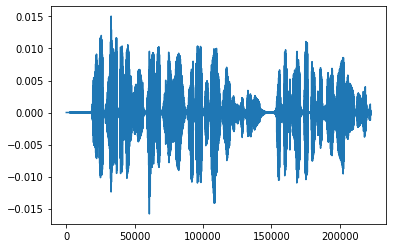

In [6]:
pl.plot(X_transformed[:,0])

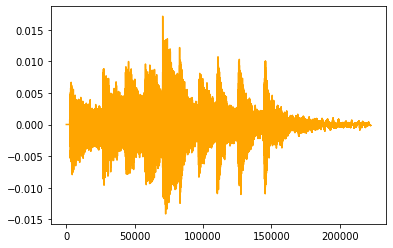

In [7]:
pl.plot(X_transformed[:,1], c='orange')

#### 3. Créer les fichiers audio pour chaque source extraite et les écouter.

In [8]:
wavwrite('snd/mix_1.wav', X_transformed[:,0])
ipd.Audio('./snd/mix_1.wav')

In [9]:
wavwrite('snd/mix_2.wav', X_transformed[:,1])
ipd.Audio('./snd/mix_2.wav')

## <center>- EXTRACTION DE CARACTÉRISTIQUES DE VISAGES -</center>

In [10]:
# pca_nmf_faces.py
# Authors: Vlad Niculae, Alexandre Gramfort, Slim Essid
# License: BSD
from time import time
from numpy.random import RandomState
import pylab as pl
import numpy as np
from sklearn.datasets import fetch_olivetti_faces 
from sklearn import decomposition
# -- Prepare data and define utility functions ---------------------------------
n_row, n_col = 2, 5
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data
n_samples, n_features = faces.shape
# global centering
faces_centered = faces - faces.mean(axis=0, dtype=np.float64)
print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


2773 negative-valued pixels
2630 negative-valued pixels
1422 negative-valued pixels
1242 negative-valued pixels
1004 negative-valued pixels
2049 negative-valued pixels
1580 negative-valued pixels
1387 negative-valued pixels
3819 negative-valued pixels


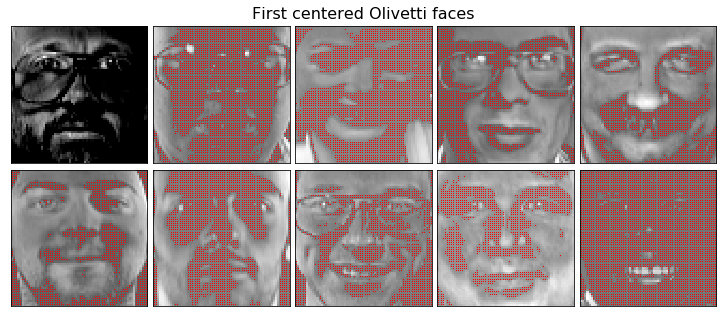

In [12]:
def plot_gallery(title, images): 
    pl.figure(figsize=(2. * n_col, 2.26 * n_row)) 
    pl.suptitle(title, size=16)
    for i, comp in enumerate(images):
        pl.subplot(n_row, n_col, i + 1)
        comp = comp.reshape(image_shape) 
        vmax = comp.max()
        vmin = comp.min()
        dmy = np.nonzero(comp<0)
        if len(dmy[0])>0: 
            yz, xz = dmy 
        comp[comp<0] = 0
        
        pl.imshow(comp, cmap=pl.cm.gray, vmax=vmax, vmin=vmin)
        #print "vmax: %f, vmin: %f" % (vmax, vmin)
        #print comp
        if len(dmy[0])>0:
            pl.plot( xz, yz, 'r,')
            print(len(dmy[0]), "negative-valued pixels")
        pl.xticks(())
        pl.yticks(())
    pl.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
# Plot a sample of the input data
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])
# -- Decomposition methods -----------------------------------------------------

Extracting the top 10 Eigenfaces - PCA...
done in 0.118s
3998 negative-valued pixels
2078 negative-valued pixels
1967 negative-valued pixels
1862 negative-valued pixels
2261 negative-valued pixels
1924 negative-valued pixels
1951 negative-valued pixels
1883 negative-valued pixels
2221 negative-valued pixels
2127 negative-valued pixels
Extracting the top 10 Non-negative components - NMF...
done in 9.589s


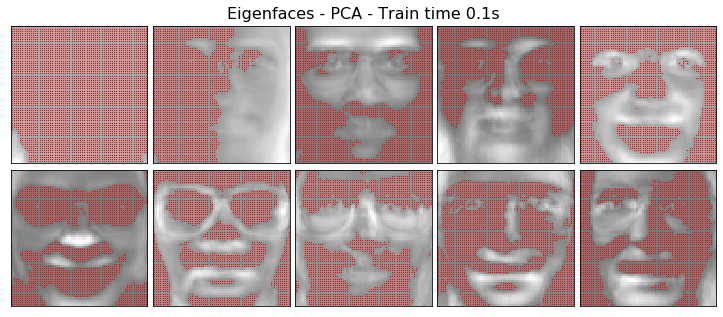

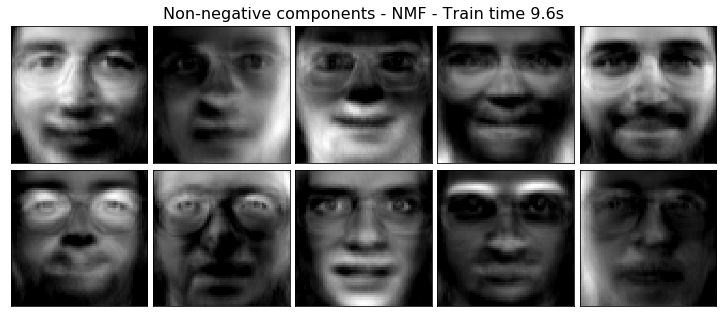

In [13]:
# List of the different estimators and whether to center the data
estimators = [
    ('pca', 'Eigenfaces - PCA',
     decomposition.PCA(n_components=n_components, whiten=True), 
     True),
    ('nmf', 'Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init=None, tol=1e-6, max_iter=2000),
     False) ]
# -- Transform and classify ----------------------------------------------------
labels = dataset.target
X = faces
X_ = faces_centered
for shortname, name, estimator, center in estimators:
    #if shortname != 'nmf': continue
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = X
    if center:
        data = X_
    data = estimator.fit_transform(data)
    
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

#### 2. Modifier le script pour réaliser une évaluation des performances d’un système de recon- naissance automatique de visages utilisant les caractéristiques extraites par PCA, compa- rées à celles obtenues par un système exploitant les caractéristiques extraites par NMF. On pourra utiliser la LDA pour la classification. On effectuera l’évaluation par validation croisée. On observera l’évolution des scores en faisant varier le nombre de composantes utilisé dans les décompositions.

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [16]:
accuracy_pca = []
accuracy_nmf = []

for n_components in [6, 10, 14, 18, 25, 50] :
    estimators = [
        ('pca', 'Eigenfaces - PCA',
         decomposition.PCA(n_components=n_components, whiten=True),True),

        ('nmf', 'Non-negative components - NMF',
         decomposition.NMF(n_components=n_components, init=None, tol=1e-6,max_iter=1000),False)
    ]

    labels = dataset.target
    X = faces
    X_ = faces_centered

    for shortname, name, estimator, center in estimators:

        #print("Extracting the top %d %s..." % (n_components, name))
        t0 = time()

        data = X
        if center:
            data = X_
        
        ### Fit Transform Data  
        data = estimator.fit_transform(data)
    
        ### Fit the LDA
        clf = LinearDiscriminantAnalysis()
        y_pred = cross_val_score(clf, data, labels, cv=5)
        
        if shortname == 'pca' :
            accuracy_pca.append(y_pred.mean())
        else :
            accuracy_nmf.append(y_pred.mean())
        print("Accuracy Score " + str(name) + ": " + str(round(y_pred.mean(),2)))
    
        train_time = (time() - t0)
        #print("done in %0.3fs" % train_time)
    
        components_ = estimator.components_

        #plot_gallery('%s - Train time %.1fs' % (name, train_time),omponents_[:n_components])
        #plt.show()

Accuracy Score Eigenfaces - PCA: 0.69
Accuracy Score Non-negative components - NMF: 0.69
Accuracy Score Eigenfaces - PCA: 0.84
Accuracy Score Non-negative components - NMF: 0.88
Accuracy Score Eigenfaces - PCA: 0.91
Accuracy Score Non-negative components - NMF: 0.91
Accuracy Score Eigenfaces - PCA: 0.94
Accuracy Score Non-negative components - NMF: 0.94
Accuracy Score Eigenfaces - PCA: 0.96
Accuracy Score Non-negative components - NMF: 0.97
Accuracy Score Eigenfaces - PCA: 0.97
Accuracy Score Non-negative components - NMF: 0.97


## <center>- EXTRACTION DE THÈMES À PARTIR DE TEXTES -</center>

In [23]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck <L.J.Buitinck@uva.nl>
# License: BSD 3 clause

from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english')
tfidf = vectorizer.fit_transform(dataset.data[:n_samples])
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Loading dataset and extracting TF-IDF features...
done in 26.350s.
Fitting the NMF model with n_samples=2000 and n_features=1000...
done in 26.549s.
Topic #0:
just people don think like know say did make really time way ve right sure good going want got wrong

Topic #1:
windows use using window dos program application os drivers software help screen running ms code motif pc work ve mode

Topic #2:
god jesus bible faith does christian christians christ believe life heaven sin lord church religion true mary human belief love

Topic #3:
thanks know does mail advance hi info interested anybody email like looking help appreciated card information list send need post

Topic #4:
car new 00 bike 10 price space cars power sale good year engine years used cost miles condition great 000

Topic #5:
edu soon com send university internet ftp mail mit information article cc pub address hope program email mac blood contact

Topic #6:
file problem files format ftp win space sound read pub available pro